# A Simple Virtual Makeup Tutorial
This notebook is a Python tutorial walking through use of DLib's Face Detector and Face Landmarks Predictor, within the framework of an OpenCV Python script. The implementation is applying virtual makeup to a person's face after locating their face using DLib's Face Detector and Face Landmarks Predictor. This is suitible for single image or video stream usage. Demonstrated by this tutorial is how to apply four simple forms of virtual makeup:

1. Eyeliner/mascara
2. Lipstick
3. Eye color change
4. Age/Wrinkle smoothing

First a set of utility functions are detailed specific to virtual makeup. Then each form of virtual makeup is implemented, details described, and finally demonstrated. 

Before we begin, make sure you have a Python environment with the following dependencies installed:<br>
**OpenCV, DLib, Numpy** and for this tutorial only **Matplotlib.**<br>
Note: due to the variety of possible Python setups, this tutorial does not describe how one installs these dependencies to your development environment. 

### We begin with the import of the environment our application requires to run:

In [177]:
import cv2,sys,dlib,time,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Tutorial configuration
This next block of code is configuration for the tutorial. Required for the virtual makeup routines' facial landmark input, DLib's face finder and face shape predictor are loaded. A sample face image is loaded, a few copies of the image are created for different needed, some utility functions are defined, and finally the image's facial landmarks are located and displayed.

Eye distance: 190.01
Facial landmarks: [(216, 374), (217, 410), (224, 445), (233, 480), (242, 514), (257, 546), (282, 572), (311, 593), (348, 599), (388, 596), (428, 580), (463, 558), (487, 526), (500, 488), (507, 448), (510, 408), (511, 369), (226, 341), (243, 325), (269, 324), (294, 333), (316, 345), (360, 344), (386, 330), (415, 321), (446, 321), (471, 334), (337, 374), (336, 397), (335, 419), (334, 442), (315, 464), (326, 468), (338, 471), (351, 467), (363, 465), (252, 377), (269, 368), (290, 370), (308, 385), (288, 391), (266, 389), (382, 385), (401, 369), (423, 367), (442, 375), (427, 388), (404, 390), (293, 517), (310, 503), (327, 496), (341, 500), (356, 496), (377, 503), (400, 514), (379, 528), (358, 534), (342, 536), (327, 535), (311, 529), (302, 516), (327, 512), (341, 512), (356, 511), (392, 513), (356, 512), (341, 513), (327, 513)]


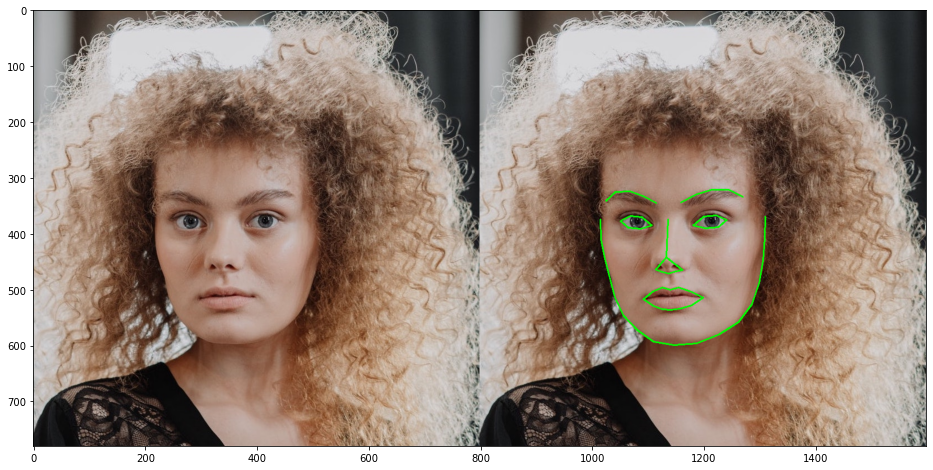

In [190]:
# DLib's facial landmark model is expected at this path:
PREDICTOR_PATH =  "shape_predictor_68_face_landmarks.dat"

# Get the face detector:
faceDetector = dlib.get_frontal_face_detector()

# Facial landmark predictor is implemented in the shape_predictor class
faceLandmarkPredictor = dlib.shape_predictor(PREDICTOR_PATH)

# load an example image:
im = cv2.imread("girl-no-makeup.jpg")

# DLib works with RGB, but OpenCV loads in BGR, so convert from BGR
imDlib = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#
imDlibMarked = imDlib.copy() # will receive face landmarks, copy is for demo use only

imDlibf = np.float32(imDlib) # a float BGR version for passage to the makeup application functions

# utility that renders the face landmarks as a series of lines:
def drawDetectedFace( im, points, color=(255,255,255), thickness=1 ):
    if len(points)==68:
        for i in range(0,16):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)
        for i in range(36,41):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)
        cv2.line(im,tuple(points[36]),tuple(points[41]),color,thickness)
        for i in range(42,47):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)
        cv2.line(im,tuple(points[42]),tuple(points[47]),color,thickness)
        for i in range(48,59):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)
        cv2.line(im,tuple(points[48]),tuple(points[59]),color,thickness)
        for i in range(27,35):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)
        cv2.line(im,tuple(points[30]),tuple(points[35]),color,thickness)
        for i in range(17,21):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)
        for i in range(22,26):
            cv2.line(im,tuple(points[i]),tuple(points[i+1]),color,thickness)

# Function to calculate the distance the eyes span. Returns a float. 
# Used as a face scale so digital makeup does not change with face distance from camera.
def eyeDistance(landmarks):
  leftEyeLeftCorner = (landmarks[36][0], landmarks[36][1]) # left outside eye corner
  rightEyeRightCorner = (landmarks[45][0], landmarks[45][1]) # right outside eye corner
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  return distance

# calc fraction for resizing for faster face detection:
RESIZE_HEIGHT = 360
height = im.shape[0]
IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
#
# create the smaller image used for faster face detection:
imSmallDlib = cv2.resize(imDlib, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
#
# detect faces with no upscale (2nd parameter):
faces = faceDetector(imSmallDlib,0) 

landmarks = [] # will receive facial landmarks
eyeDist = -1   # will hold distance between eyes

if len(faces)>0:
    # Face detector was run over a smaller image. So, we scale face rectangle to correct size:
    newRect = dlib.rectangle(int(faces[0].left() * IMAGE_RESIZE),
                             int(faces[0].top() * IMAGE_RESIZE),
                             int(faces[0].right() * IMAGE_RESIZE),
                             int(faces[0].bottom() * IMAGE_RESIZE))
    
    # passing the rescaled face rect to the face landmark predictor, we get face landmark points back:
    dlibPointList = faceLandmarkPredictor(imDlib, newRect).parts()  
    
    # the above returns a list of "DLib points", but we don't want that "DLib point" structure,
    #  so this dereferences them to just be a 2-element tuple list:
    [landmarks.append((p.x, p.y)) for p in dlibPointList]   # dereference to a 2-element tuple list

    # render the facial landmarks into imDlibMarked, created earlier for this use:
    drawDetectedFace( imDlibMarked, landmarks, color=(0,255,0), thickness=2 )
    
    eyeDist = eyeDistance(landmarks)
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, imDlibMarked) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(wip)
    print("Eye distance: {:.2f}".format(eyeDist))
    print("Facial landmarks: {}".format(landmarks))

### Virtual Makeup Low Level Utilities:
The following utility functions form the low level basis of the virtual makeup functions:
- **dereferencePoints( points, indexesToPoints )**
  - *points* is a list of points, i.e. a list of 2-value (x,y) tuples 
  - *indexesToPoints* is used to create and return a new point list
  - This returns a new point list equal to the dereferencing of *indexesToPoints* into *points*
- **fillConcavePolygon( im, points, indexesToPoints, color=(255,255,255) )**
  - *im* is the Mat image a concave polygon will be rendered
  - *points* is a list of point tuples
  - *indexesToPoints* is a list of idexes into *points*, defining the polygon that is to be rendered
  - *color* is the BGR color the polygon will be rendered, defaulting to white as (255,255,255)
  - This returns *im* with the polygon defined by *points* and *indexesToPoints* rendered in *color*.
- **fillConvexPolygon( im, points, indexesToPoints, color=(255,255,255) )**
  - *im* is the Mat image a convex polygon will be rendered
  - *points* is a list of point tuples
  - *indexesToPoints* is a list of idexes into *points*, defining the polygon that is to be rendered
  - *color* is the BGR color the polygon will be rendered, defaulting to white as (255,255,255)
  - This returns *im* with the polygon defined by *points* and *indexesToPoints* rendered in *color*.
- **interpolatePoint2D(basePt, remotePt, percent)**
  - *basePt* is the origin point of the interpolation
  - *remotePt* is the non-origin point of the interpolation
  - *percent* is a normalized value defining the function return value. When *percent* is equal to 0.0 the return value is equal to *basePt*, when *percent* is equal to 1.0 the return value is equal to *remotePt*, and any value of *percent* between 0.0 and 1.0 will return the point that is *percent * 100* of the way between *basePt* and *remotePt*.
- **alphaBlend(alpha, foreground, background)**
  - *alpha* is a Mat image defining the per-pixel mixing of *foreground* and *background*. *Foreground* and *background* are Mat images and expected to be the same shape as *alpha*. Pixels values within *alpha* are expected to range from 0 to 255. Each pixel in *alpha* is the weighting factor for mixing the corresponding *foreground* and *background* pixels from their corresponding image. 
  - *foreground* is a Mat image whose pixels are given preference where the corresponding pixels' in *alpha* are close to 255.
  - *background* is a Mat image whose pixels are given preference where the corresponding pixels' in *alpha* are close to 0.
  - This returns a new Mat image with the same shape as *alpha* that is the weighted average between *foreground* and *background*, where each pixel in *alpha* is the weighted average to use when mixing foreground and background pixels.
  
At the lowest conceptual level are these functions. Common to the first three functions are the *points* and *indexesToPoints* lists. *Points* is, for us, the **68-point facial landmarks** returned by **DLib's face landmark predictor**. *IndexesToPoints* is a list of integer indexes into *points* defining a polygon. Both **fillConcavePolygon()** and **fillConvexPolygon()** use **dereferencePoints()** to carry out their work. Other than those two routines, **dereferencePoints()** is unused by the rest of the application. 

The purpose of **fillConcavePolygon()** and **fillConvexPolygon()** is the creation of mask images. Mask images are used to *mask out portions of an image* for isolation of some portion of an image for further analysis. These both default to rendering in white (255,255,255), implying the pixel scale is 0-255. Because lips can easily deform, as well as the upper lip being concave in nature, the masks for lips uses the concave fill to insure correct mask generation. 

Where **DLib's 68-point facial landmarks** does not include forehead points above the eyebrows, **interpolatePoint2D()** is used to create forehead points when needed. This is demonstrated in the Age/Wrinkle Smoothing implementation. 

In order to create and apply virtual makeup, mask images are created and used to filter further processing. The **alphaBlend()** function is used to composite two images together. In the context of virtual makeup, one of the images being composited is the usually target image, the other is the virtual makeup color, and the mask defines where the makeup is applied. 

Here is the implementation of these low level utility functions:

In [179]:
def dereferencePoints(actualPoints, indexesToPoints):
    retPoints = []
    for pIndex in indexesToPoints:
        retPoints.append(actualPoints[pIndex])
    return retPoints

def fillConcavePolygon(mask, points, indexesToPoints, color=(255,255,255)):
    polyPts = dereferencePoints(points, indexesToPoints)
    cv2.fillPoly(mask, [np.int32(polyPts)], color)

def fillConvexPolygon(mask, points, indexesToPoints, color=(255,255,255)):
    polyPts = dereferencePoints(points, indexesToPoints)
    cv2.fillConvexPoly(mask, np.int32(polyPts), color)
    
def interpolatePoint2D(basePt,remotePt,percent):
    betweenPt = ( ((remotePt[0] - basePt[0]) * percent + basePt[0]),
                  ((remotePt[1] - basePt[1]) * percent + basePt[1]) )
    return betweenPt

def alphaBlend(alpha, foreground, background):
    # start with an empty mat, but sized correctly and a float type:
    fore = np.empty_like(foreground, dtype=np.float32)

    # produce a float version of our foregound image with our mask:
    fore = cv2.multiply(alpha, foreground, fore, 1/255.0)

    # produce an inverted version of the floating mask:
    alphaPrime = np.ones(alpha.shape, dtype=alpha.dtype)*255 - alpha

    # make empty mat sized correctly and of float type to hold our result:
    back = np.empty_like(background, dtype=float)

    # produce final background image through our inverted mask applied to the original background
    back = cv2.multiply(alphaPrime, background, back, 1/255.0)

    # both foreground and background are masked,
    # so just add them to produce our blended image:
    outImage = cv2.add(fore, back)

    return outImage

### Creating an Eyeliner/Mascara Mask
Using the above low level functions, plus support from OpenCV and Numpy the following Python demonstrates how to create a mask image through which an Eyeliner/Mascara image effect can be applied. 

Note the use of the *eye distance* parameter as a face scale. When calculating the size of a blur kernel, for example, in the function below, the distance between the eyes is used to calculate the blur kernel size. This insures that as face distance from the camera varies, blur kernels scale appropriately. Otherwise image effects, such as the eyeliner/mascara mask defined below would produce eyeliner that becomes thicker as distance from the camera increases. 

In [180]:
def makeEyelinerMask(size, points, eyeDist):
    # Left eye polygon indexes into points
    leftEye = [36, 37, 38, 39, 40, 41]
    # Right eye polygon indexes into points
    rightEye = [42, 43, 44, 45, 46, 47]

    # mask starts out as three channels of the passed size, and solid black, meaning "empty":
    mask = np.zeros((size[0], size[1], 3), dtype=np.uint8)
    
    # fill each eye polygon with white (white being the default color):
    fillConvexPolygon( mask, points, leftEye)
    fillConvexPolygon( mask, points, rightEye)

    # going to create some points approximating the "cat eyeliner" popular right now:
    leftLid = []
    leftLid.append(points[39])
    leftLid.append(points[38])
    leftLid.append(points[37])
    leftLid.append(points[36])
    #
    lidCoord = interpolatePoint2D( points[36], points[17], 0.15 )
    leftLid.append(lidCoord)
    #
    lidCoord = interpolatePoint2D( points[37], points[18], 0.1 )
    leftLid.append(lidCoord)
    #
    lidCoord = interpolatePoint2D( points[38], points[20], 0.1 )
    leftLid.append(lidCoord)
    #
    cv2.fillPoly(mask, [np.int32(leftLid)], (255, 255, 255))
    #
    rightLid = []
    rightLid.append(points[42])
    rightLid.append(points[43])
    rightLid.append(points[44])
    rightLid.append(points[45])
    #
    lidCoord = interpolatePoint2D( points[45], points[26], 0.15 )
    rightLid.append(lidCoord)
    #
    lidCoord = interpolatePoint2D( points[44], points[25], 0.1 )
    rightLid.append(lidCoord)
    #
    lidCoord = interpolatePoint2D( points[43], points[23], 0.1 )
    rightLid.append(lidCoord)
    #
    cv2.fillPoly(mask, [np.int32(rightLid)], (255, 255, 255))
    
    # At this point we have a black mask image with solid white "cat eye" shaped white
    # blobs located pixel-wise over the eyes of the face in our target image.
    # Going to create our eyeliner by hard blurring these blobs, creating a fade of 
    # eyeliner/mascara around each eye socket.
    # 
    # We want the blur to be consistent with the distance of the face from the camera,
    # so using the eyeDist as the blur scale, and we want a more vertical blur, so:
    blurScaleX = int(eyeDist / 35)*2+1 # 
    blurScaleY = int(eyeDist / 15)*2+1
    #
    # this blurring is our eyeliner/mascara fade away from the eye socket:
    mask = cv2.GaussianBlur(mask, (blurScaleX, blurScaleY), 0, 0)
    #
    # the original filling of the eye-holes was purely to seed the above blur,
    # now we don't want the eye holes included in the mask, so cut them out:
    fillConvexPolygon(mask, points, leftEye, (0,0,0))
    fillConvexPolygon(mask, points, rightEye, (0,0,0))
    #
    # final softening for the edge of the just-cut-out eyeholes:
    mask = cv2.GaussianBlur(mask, (blurScaleX, blurScaleX), 0, 0)
    #
    return mask # all done!

Note the following points of interest in the function creating an eyeliner/mascara mask:
- On line 8, the mask Mat image is created using the passed size, with Numpy uint8's for the BGR pixel channels. Using uint8's for the mask's pixels tends to be faster, despite being converted to float pixels after creation. 
- Notice lines 21, 24, 27, 38, 41, and 44: those lines demonstrate the creation of a polygon formed by the upper eyelid with a "cat triangle outside tip". That code uses **interpolatePoint2D()** to define the "cat triangle tip" as some percentage between upper eyelid points and points on the corresponding eyebrow. Because this upper eyelid masking could create a convex polygon, the slower convex polygon capable cv2.fillPoly() OpenCV function is used for the actual polygon render defining the eyeliner/mascara mask. 
- On line 49 the final creation of the eye makeup mask is achieved by blurring the just created solid-white eye sockets to create a fade effect of masking away from the eye sockets. Likewise, this blurring is stronger vertically, simply because my guy-eyes thinks that looks better. 

Next is a demonstration of creating an eyeliner/mascara mask by calling the above, which also calls the low level routines described earlier.

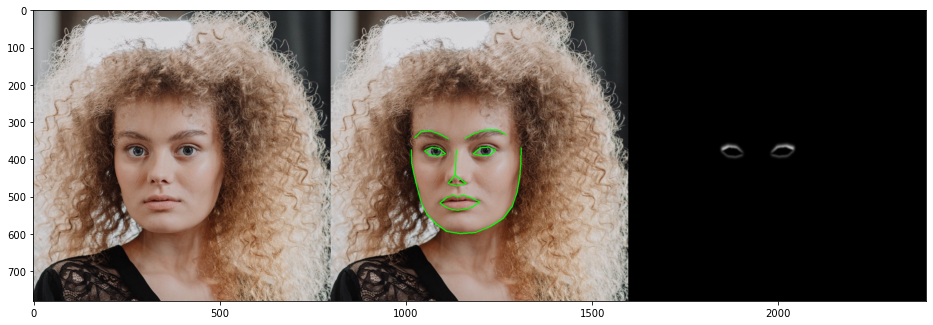

In [181]:
# an "if" is used in each demo block to insure we're working with a valid image:
if len(landmarks)>0:
    # note how the shape is used to create the first parameter
    eyelinerMask = makeEyelinerMask( im.shape[0:2], landmarks, eyeDist )
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, imDlibMarked, eyelinerMask) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(wip)

In practice, the eyeliner/mascara mask function is only called by the function that applies eyeliner/mascara:

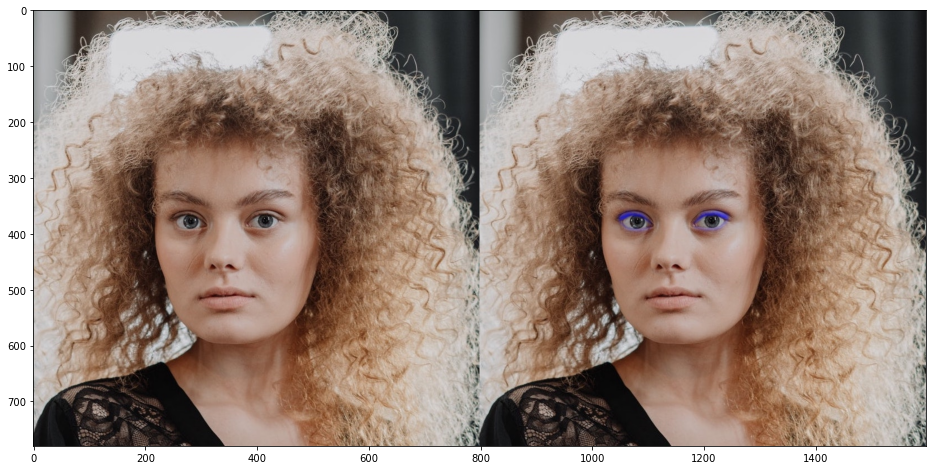

In [182]:
def applyEyeliner( imf, landmarks, eyeDist, eyeColor=(32.0,32.0,240.0) ):
    eyelinerMask = makeEyelinerMask( imf.shape[0:2], landmarks, eyeDist )
    eyelinerMask = eyelinerMask.astype(np.float32)
    #
    eyeMakeup = np.ones((imf.shape[0], imf.shape[1], 3), dtype=np.float32)
    eyeMakeup[:] = eyeColor
    #
    eyeMakeupApplied = alphaBlend( eyelinerMask, eyeMakeup, imf )
    #
    return eyeMakeupApplied

if len(landmarks)>0:
    wip = applyEyeliner( imDlibf, landmarks, eyeDist )
    
    wip = wip.astype(np.uint8)
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, wip) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(wip)

### Creating a Lipstick Mask
Similar in process to creating the eyeliner/mascars mask above, lipstick mask creation varies only by the use of different polygons, and the use of concave polygon rendering. Concave polygon rendering is used because deforming lips can easily be non-convex. 

In [183]:
def makeLipsMask(size, points, eyeDist):
    # upper lip polygon
    upperLip = [48, 49, 50, 51, 52, 53, 54, 64, 63, 62, 61, 60]
    # lower lip polygon
    lowerLip = [48, 59, 58, 57, 56, 55, 54, 64, 65, 66, 67, 60]
    # inside lips polygon
    insideLips = [60, 61, 62, 63, 64, 65, 66, 67]

    # mask starts out as black and the passed size:
    mask = np.zeros((size[0], size[1], 3), dtype=np.uint8)

    # add the upper lip:
    fillConcavePolygon( mask, points, upperLip, (64,64,64) )

    # add the lower lip:
    fillConcavePolygon( mask, points, lowerLip, (80,80,80) )

    # outline the lips so the lip color "pops"
    for i in range(48,59):
      cv2.line(mask,tuple(points[i]),tuple(points[i+1]),(128,128,128),1)
    cv2.line(mask,tuple(points[48]),tuple(points[59]),(128,128,128),1)

    # using the eyeDist as the blur scale:
    blurScale = int(eyeDist / 40)*2+1
    # soften
    mask = cv2.GaussianBlur(mask, (blurScale, blurScale), 0, 0)

    # Remove inside mouth from the mask
    fillConvexPolygon(mask, points, insideLips, (0,0,0))

    # soften again
    mask = cv2.GaussianBlur(mask, (blurScale, blurScale), 0, 0)

    return mask

Note the following points of interest in the function creating a lipstick mask:
- Notice lines 13 and 16 each render concave polygons, because lips are often concave.
- Also notice in lines 13 and 16 the colors applied are not white, and not the same color. This is because fashion-minded women will often have a slightly different shade on their upper lip than on their lower lip. 
- Lines 19 - 20 outline the lips in yet another color, in an attempt to give the lipstick a more dramatic appearance. 
- Line 24 shows the eye distance being used to calculate the blur diameter, so the blur does not vary with the face's distance from the camera. 

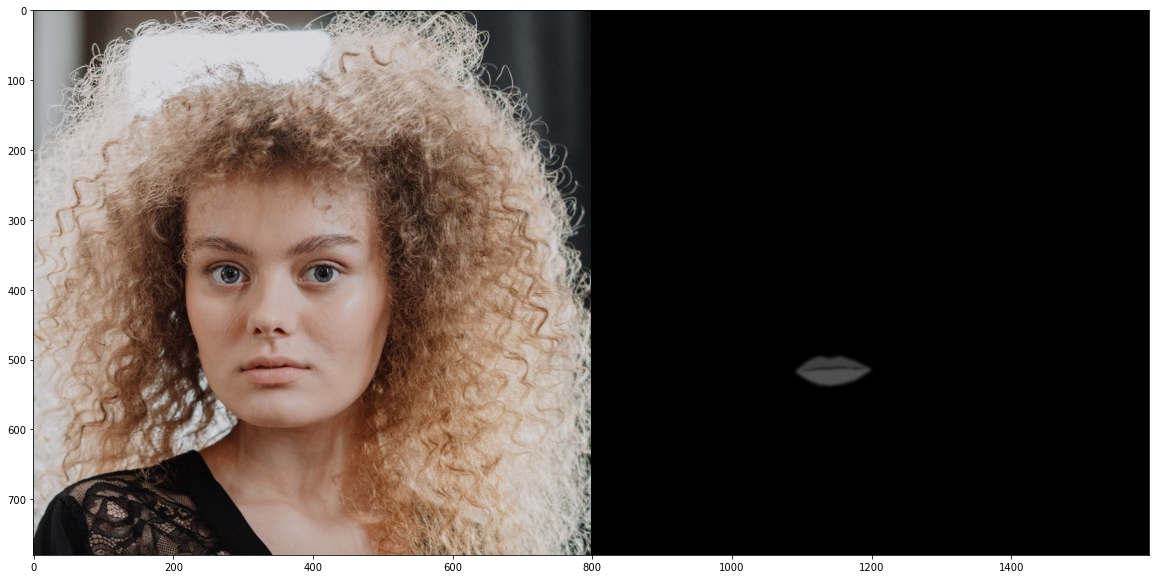

In [184]:
if len(landmarks)>0:
    # note how the shape is used to create the first parameter
    lipstickMask = makeLipsMask( im.shape[0:2], landmarks, eyeDist )
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, lipstickMask) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    plt.imshow(wip)

Generating a lipstick mask is most the work of virtual lipstick. Here's a routine that given a float-pixel version of an image, a set of face landmarks, and the eyeDist it returns a new float-pixel image with virtual lipstick applied:

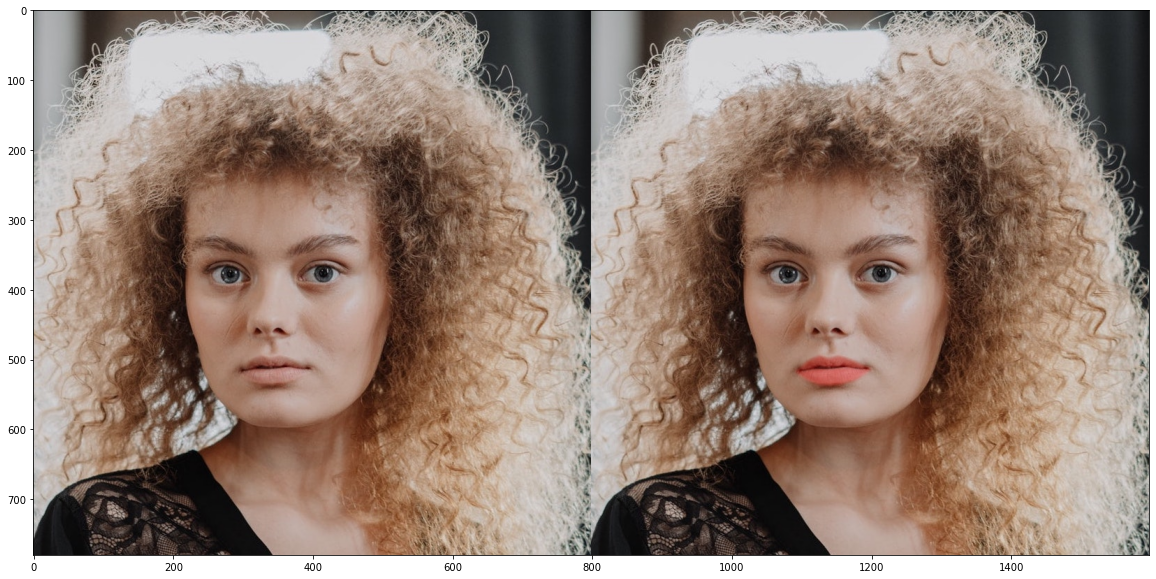

In [185]:
def applyLipstick( imf, landmarks, eyeDist, lipColor=(255.0,32.0,32.0) ):
  # create the lip mask:
  lipsMask = makeLipsMask( imf.shape[0:2], landmarks, eyeDist  )
  lipsMask = lipsMask.astype(np.float32) # need with float pixels
  #
  lipstick = np.ones((imf.shape[0], imf.shape[1], 3), dtype=np.float32)
  lipstick[:] = lipColor
  #
  lipstickApplied = alphaBlend( lipsMask, lipstick, imf )
  #
  return lipstickApplied

if len(landmarks)>0:
    # note how the shape is used to create the first parameter
    lipstickApplied = applyLipstick( imDlibf, landmarks, eyeDist )
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, lipstickApplied.astype(np.uint)) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    plt.imshow(wip)

### Creating an Eyes Mask for Creating an Iris Mask
In this application, an Eyes Mask is subtly different from previous masks. Where previous masks are used to isolate portions of a face image for application of a color that is the color of the virtual makeup. The Eyes Mask is used to isolate the eyeball area for further computer vision processing. The eyeballs are complex, so a divide and conquer strategy is being used: to change the iris color we first need a mask isolating the eyeballs from the rest of the face. Once only working with eyeball pixels, we can concern ourselves with distinguishing the iris from the rest of the eyeball. 

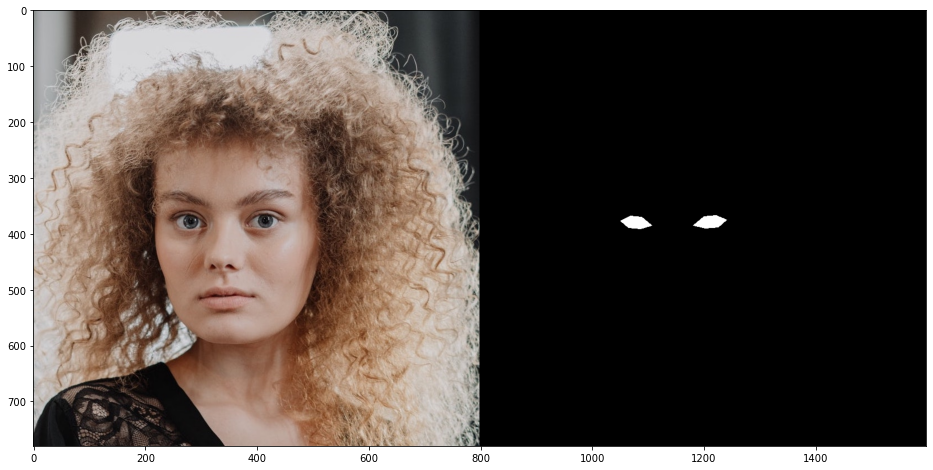

In [191]:
def makeEyesMask(size, points, eyeDist):
    # Left eye polygon
    leftEye = [36, 37, 38, 39, 40, 41]
    # Right eye polygon
    rightEye = [42, 43, 44, 45, 46, 47]

    # mask starts out as black and the passed size:
    mask = np.zeros((size[0], size[1], 3), dtype=np.uint8)
    #
    # fill each eye polygon with white: 
    fillConvexPolygon( mask, points, leftEye)
    fillConvexPolygon( mask, points, rightEye)

    # where other mask have a blur here, we want to use
    # this mask for further logic, so no blur. 

    return mask

# here's inline use of the above purely to generate the demo output below:
if len(landmarks)>0:
    
    eyesMask = makeEyesMask( imf.shape[0:2], landmarks, eyeDist )
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, eyesMask) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(wip)

By this point, the repeating pattern nature of the code creating these masks should be noticible: 
* Define some polygon data, 
* create a black image, this is defining an empty mask, 
* render polygons into the mask image, 
* blur the mask image if being used for pixel manipulation, otherwise is used for logic and do not blur
* return the mask image. 

The main change when creating different masks is the polygons that are rendered. The fact that these images are being used as masks is purely because we choose to use them as masks. The same routines could be used for rendering  colored polygons into images for viewing, just the same. 

Now that we have an Eyes Mask for further computer vision procesing, here is the remainder of that processing to create an Iris Mask and finally implement an iris color change:

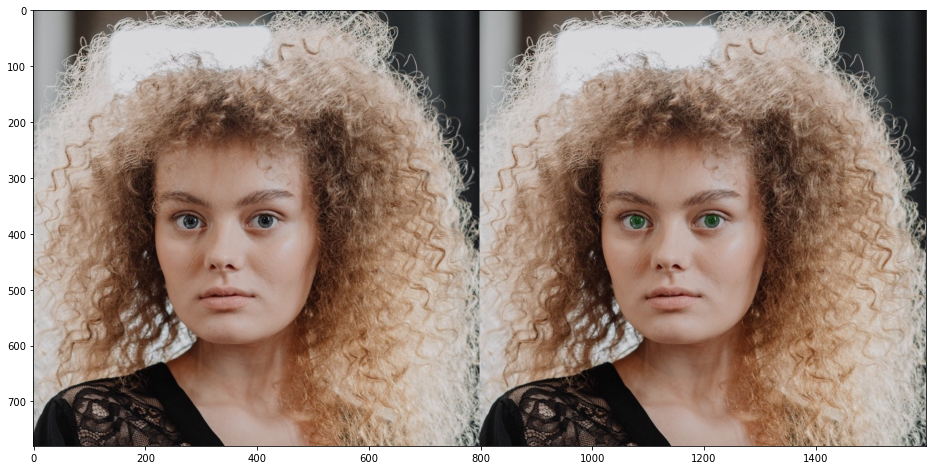

In [192]:
def changeIrisColor( imf, landmarks, eyeDist, irisColor=(32.0,255.0,32.0) ):
    # create a mask for the interior of the eyelids (the eyeballs)
    eyesMask = makeEyesMask( imf.shape[0:2], landmarks, eyeDist )
    # need that mask as float pixels:
    eyesMask = eyesMask.astype(np.float32)

    # convert to HSV to use the "V" as the gray channel:
    # Note: the input image is expected to be RGB, as is expected by DLib!
    eyesOnlyHSVf = cv2.cvtColor(imf, cv2.COLOR_RGB2HSV)

    # going to work with 1-channel imagery for a bit, so convert to 1-channel:
    eyesMask0,eyesMask1,eyesMask2 = cv2.split(eyesMask)

    # split eyesOnlyHSVf to produce the 'val' (grayscale) channel we're seeking:
    hue,sat,val = cv2.split(eyesOnlyHSVf)

    # create an empty image that will hold only the eyeballs: 
    eyesOnlyf = np.empty_like(val, dtype=np.float32)

    # cut the eyes out of the larger image:
    cv2.multiply(val, eyesMask0, eyesOnlyf, 1/255.0)

    # starting the iris isolation logic:
    # make the eyeballs inverted so the Sclera is darker than the iris
    eyesOnlyInvertedf = 255.0 - eyesOnlyf

    # threshold out the Sclera (the white portion of the eyes):
    ret, irisInvertf = cv2.threshold( eyesOnlyInvertedf, 187.0, 255.0, cv2.THRESH_BINARY)

    irisf = np.empty_like(eyesMask0, dtype=np.float32)
    #
    # cut the eyes out of the larger image again:
    cv2.multiply(irisInvertf, eyesMask0, irisf, 1/255.0)

    # apply a soft blur so the edges of what has been cut is not so harsh:
    irisf = cv2.GaussianBlur(irisf, (3, 3), 0, 0)

    # now we have a mask suitable to change the iris color, but let's reduce because we're only tinting:
    irisf = irisf * 0.15

    # merge irisf into a 3-channel float mask image:
    finalEyesMask = cv2.merge((irisf,irisf,irisf))

    newEyeColor = np.ones((imf.shape[0], imf.shape[1], 3), dtype=np.float32)
    newEyeColor[:] = irisColor
    #
    finalFinal = alphaBlend( finalEyesMask, newEyeColor, imf )
    #
    return finalFinal

# here's inline use of the above purely to generate the demo output below:
if len(landmarks)>0:
    # changeIrisColor() has a different 1st parameter than the mask generating functions;
    # parameter 1 is the target image, in float format:
    differentEyeColor = changeIrisColor( imDlibf, landmarks, eyeDist )
    
    wip = differentEyeColor.astype(np.uint8)
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (imDlib, wip) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(wip)

Notice the following aspects of the iris isolation and re-coloring code:
- Expects the input Mat image in float RGB format.
- The input image is converted to HSV, and the V channel is used as a grayscale version of the input image.
- Once working with V as grayscale, further work takes place with 1-channel imagery only.
- The 1-channel imagery is used to isolate the iris from the Sclera (the white portion of the eyes) via simple thresholding. 
  - Thresholding is the only method used, to preserve any highlights that may appear over the iris.
- After the iris pixels are isolated, all that is needed is the iris pixel locations for use as a filter when color tinting iris pixels.
- Once the Iris Mask is created, changing the iris color is very similar as any other virtual makeup: 
  - Create a new Mat image of the desired iris color and blend that into the target image through the Iris Mask.

Although this iris pixel isolation method works with our sample image, tests reveals the method suffers from *ambient color bounce*. Because the color white reflects the environment's bounce light, when a subject is in a colorful or low illumination environment the subject's *eye whites* are *not white*. Typically this is not an issue, except in cases with people whose original eye color is light green, or a light hazel. Using thresholding to isolate a lighter colored green or hazel iris from the corresponding eye white simply fails because material portions of the eye white may be the same greyscale value as material portions of a green/hazel iris. This ambient environment color bounce is often not an issue with professionally generated imagery or well illuinated spaces, but for applications such as adding virtual makeup to video with low ambient room illumination, this iris isolation method does not work very well, even with non-green/hazel eyes. The easy fix is, of course, *add illumination by turning on the lights.*

### Creating a Wrinkle Removal Mask
The final virtual makeup demonstration is a blur over the skin of the face, a low expense wrinkle removal. However, **DLib's 68-point facial landmarks** do not include forehead points above the eyebrows. To compensate, forehead points are generated with some vector math, projecting points above the eyebrows. Then a convex hull is calculated from the landmark points and the added forehead points to create a closed polygon enclosing the entire face. Finally, in a similar manner to other masks, the eye-holes and the inner mouth is removed from the mask. This is an attempt to make only skin pixels receive the de-wrinkling blur.

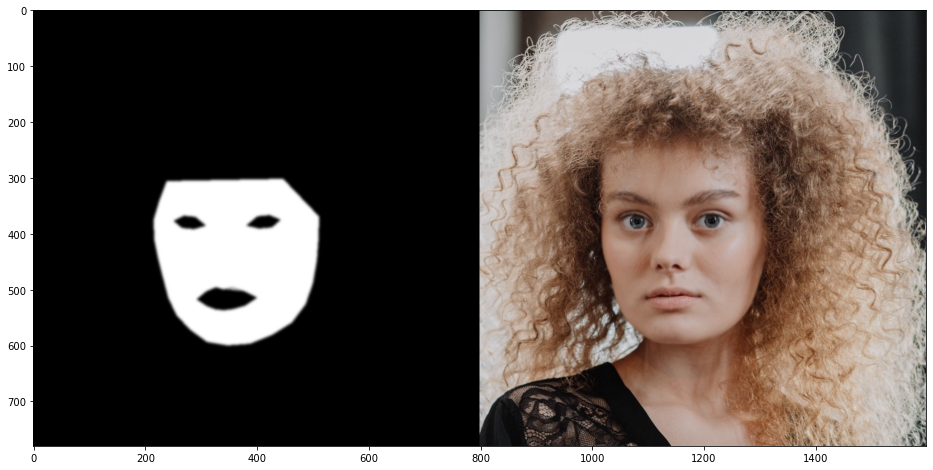

In [188]:
def appendForeheadPoints(points):
  # Building forehead points by constructing a vector between eyelid points and eyebrow points,
  # and then projecting four forehead points 35% above their corresponding eyebrow point:
  offsetScalp = 1.35
  brows = [25, 23, 20, 18]
  browsReference = [45, 47, 40, 36]
  #
  for browPoint, browRefPoint in zip(brows, browsReference):
    foreheadPointX = int(offsetScalp * (points[browPoint][0] - points[browRefPoint][0]) + points[browRefPoint][0])
    foreheadPointY = int(offsetScalp * (points[browPoint][1] - points[browRefPoint][1]) + points[browRefPoint][1])
    points.append((foreheadPointX, foreheadPointY))
    
def makeFaceMask(size, points, eyeDist):
  # Left eye polygon
  leftEye = [36, 37, 38, 39, 40, 41]
  # Right eye polygon
  rightEye = [42, 43, 44, 45, 46, 47]
  # Mouth polygon
  mouth = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
  #
  # having data type issues that are very confusing:
  plen = len(points)
  #
  if type(points) is not list:
    tmp = []
    for pIndex in range(plen):
      tmp.append(tuple(points[pIndex]))
    points = tmp
  #
  if plen==68:
    appendForeheadPoints(points)
  #
  # Find Convex hull of all points
  hullIndexes = cv2.convexHull(np.array(points), returnPoints=False)
  #
  # the return value from cv2.convexHull() has each element being a single element array
  # flatten that nonsense away. Still want indexes, just not each element being an array of one:
  tmp = []
  for oneHullIndex in hullIndexes:
    tmp.append(oneHullIndex[0])
  hullIndexes = tmp
  #
  # Create mask such that convex hull is white:
  #
  # mask starts out as black and the passed size:
  mask = np.zeros((size[0], size[1], 3), dtype=np.uint8)
  #
  # render the entire face area
  fillConcavePolygon( mask, points, hullIndexes, (255,255,255) )
  #
  # Remove inside eyelids from the mask
  fillConvexPolygon(mask, points, leftEye, (0,0,0))
  fillConvexPolygon(mask, points, rightEye, (0,0,0))
  #
  # Remove inside lips from the mask
  fillConvexPolygon(mask, points, mouth, (0,0,0))
  #
  # using the eyeDist as the blur scale:
  blurScale = int(eyeDist / 30)*2+1 
  # soften
  mask = cv2.GaussianBlur(mask, (blurScale, blurScale), 0, 0)
  #
  return mask

# here's inline use of the above purely to generate the demo output below:
if len(landmarks)>0:
    faceMask = makeFaceMask( imDlibf.shape[0:2], landmarks, eyeDist )
    #
    wip = imDlibf.copy()
    #
    blurred = cv2.GaussianBlur(wip, (5, 5), 0, 0) # blurs entire frame, not dependant on face scale
    wip[faceMask>0.0] = blurred[faceMask>0.0]
    #
    wip = wip.astype(np.uint8)
    
    # horizontally stack our work in progress for viewing:
    wip = np.hstack( (faceMask, wip) )
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(wip)

Note the above has two function definitions before the inline code for the demonstration images. 

***appendForeheadPoints()*** accepts the list of facial landmark points, and by referencing eyelid and eyebrow points, projects new forehead points above the eyebrows. These projected points define the forehead for the mask image. 

***makeFaceMask(size, points, eyeDist)*** accepts an image size for the returns mask Mat image, an array of fac landmark points, and the eye distance for use as a face scale.

This *wringle removing* is subtle and hard to notice with a youthful subject. 

# Putting the Virtual Makeup Effects Together
Finally, here's a code fragment applying all these effects to the same image: 



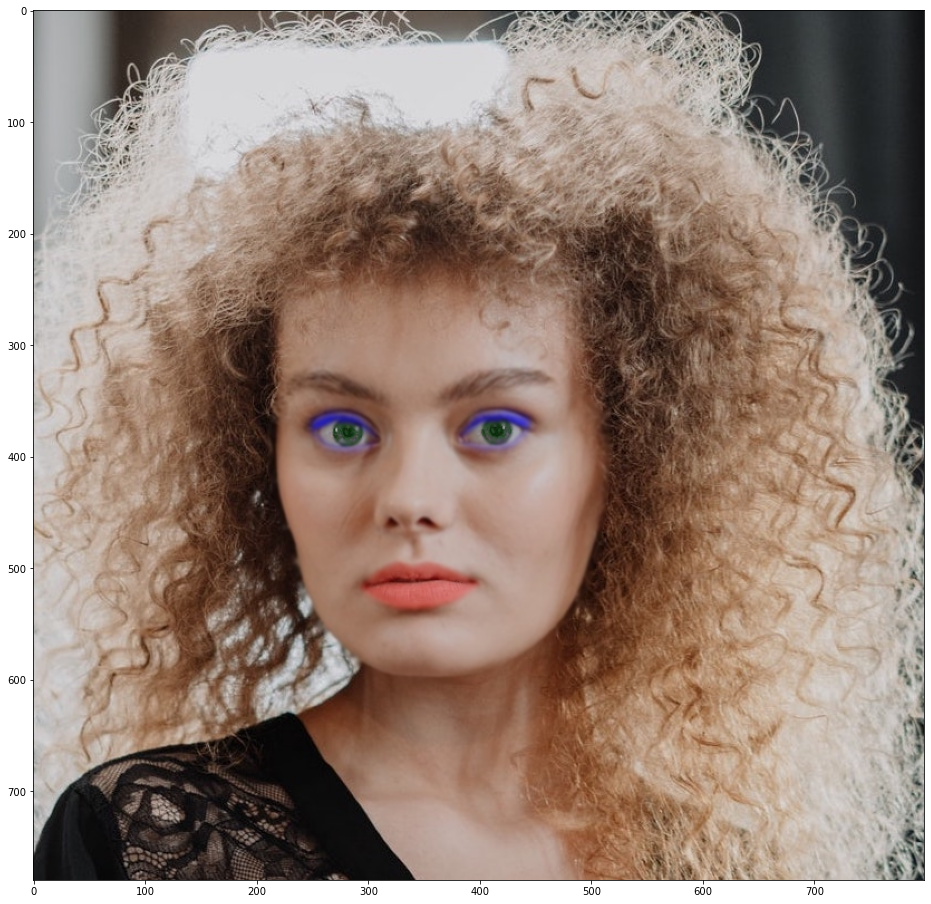

In [189]:
if len(landmarks)>0:
    eyelinerApplied = applyEyeliner( imDlibf, landmarks, eyeDist )
    lipstickApplied = applyLipstick( eyelinerApplied, landmarks, eyeDist )
    differentEyeColor = changeIrisColor( lipstickApplied, landmarks, eyeDist )
    
    faceMask = makeFaceMask( imDlibf.shape[0:2], landmarks, eyeDist )
    #
    finalFinal = differentEyeColor.copy()
    #
    blurred = cv2.GaussianBlur(finalFinal, (5, 5), 0, 0) # blurs entire frame, not dependant on face scale
    finalFinal[faceMask>0.0] = blurred[faceMask>0.0]
    #
    finalFinal = finalFinal.astype(np.uint8)
    
    # display our work in progress:
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.imshow(finalFinal)

### Summary and easy changes
The above walks through and details simple methods for applying virtual makeup. However, the implementation provides no means for the caller to specify desired colors for the target's eyeliner/mascara, lipstick, or iris. Currently the functions have hardcoded colors for each item. Adding the ability for the caller to specify the makeup color via an additional parameter to the applyEyeliner(), applyLipstick() and changeIriscolor() functions is left for the reader. 

Tests of these routines with a video stream exhibit lower than desired frame rates. An obvious optimization would be to cut each item being visually manipulated from the source image, work only on that smaller image, and then place the modified sub-image back into the original. Another level of logical indirection needs to be added to the functions to make them sub-image or entire-image agnostic. For the moment, that optimization is left to the reader. It it tempting to implement and measure the performance differece... 